# Analysis of jRCaMP1b signaling 

## Load data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from matplotlib.ticker import ScalarFormatter
from pathlib import Path
import re
import seaborn as sns
import scipy
from statannotations.Annotator import Annotator
import rushd as rd
import csv

In [2]:
# function to help convert data
def separate_nikon_df(df):
    '''
    Given the excel sheet of ROI measurements from Nikon, separate each ROI into more easily explorable dataframe.
    Also add on metadata

    Dataframe should have the following columns:
    Name	Time [s]	ND.T	ND.Z	ND.M	#1 (TxRed)	#2 (TxRed)	...

    Returns
    Dataframe with the following columns:
    Name	Time [s]	ND.T	TxRed	cond	well	order	subset
    '''
    
    # Loop through each column
    df_list = list()
    for colname in df.columns:
        # For each ROI, make into new df put into df list
        match = re.search('#(?P<ROI>\d+) \((?P<channel>.+)\)', colname)
        if match is not None:
            ROI = match.group('ROI')
            curr_df = df.loc[:, ('Name', 'Time [s]', 'ND.T', f'#{ROI} (TxRed)')]
            curr_df.rename(columns={f'#{ROI} (TxRed)': 'TxRed'}, inplace=True)
            curr_df['ROI'] = ROI
            df_list.append(curr_df)
        else:
            continue    

    # Convert list to dataframe
    data = pd.concat(df_list, ignore_index=True)

    # Add in more metadata
    match = re.search('(?P<cond>.+)_(?P<well>\w\d)_(?P<order>\d+)_(?P<subset>.+)', data.Name[0])
    data['cond'] = match.group('cond')
    data['well'] = match.group('well')
    data['order'] = match.group('order')
    data['subset'] = match.group('subset')

    return data


def calc_deltaF(df):
    '''
    Given df, calc change in fluoresence normalized by minimum fluorescence 
    '''

    # For each ROI
    for ROI in df.ROI.unique():
    
        # Calc basal levels (min fluorescence)
        F0 = np.min(df[df.ROI == ROI]['TxRed'])
        df.loc[df.ROI == ROI, 'F0'] = F0

        # Calc deltaF (F - F0)
        deltaF = df[df.ROI == ROI]['TxRed'] - F0
        df.loc[df.ROI == ROI, 'deltaF'] = deltaF

        # Calc norm deltaF (F - F0)/F0
        deltaF_norm = df[df.ROI == ROI]['deltaF']/F0
        df.loc[df.ROI == ROI, 'deltaF_norm'] = deltaF_norm

In [3]:
# Directories
datadir = rd.datadir/'2024.07.10_Ca-NTR_7dps'
figpath = '../figures/fig5/'

# Load all data
sheet =  'Data (ROIs)'

dir = 'noNTR_C2_003_analysis'
cond = 'noNTR_C2_003'
df_noNTR = separate_nikon_df(pd.read_excel(datadir/f'{cond}_analysis'/f'{cond}_ROI-measurements_after-equalize.xlsx', sheet_name=sheet))
calc_deltaF(df_noNTR)

dir = 'NTR_C3_005_analysis'
cond = 'NTR_C3_005'
df_NTR = separate_nikon_df(pd.read_excel(datadir/f'{cond}_analysis'/f'{cond}_ROI-measurements_after-equalize.xlsx', sheet_name=sheet))
calc_deltaF(df_NTR)

## Look at effect of equalization

Without NTR

In [5]:
cond = 'noNTR_C2_003'
sheet =  'Data (ROIs)'

# Read in data
df_noNTR_before = separate_nikon_df(pd.read_excel(datadir/f'{cond}_analysis'/f'{cond}_ROI-measurements_before-equalize.xlsx', sheet_name=sheet))
df_noNTR_after = separate_nikon_df(pd.read_excel(datadir/f'{cond}_analysis'/f'{cond}_ROI-measurements_after-equalize.xlsx', sheet_name=sheet))

Text(0.5, 1.0, 'No NTR, C2, 003\nBefore equalize')

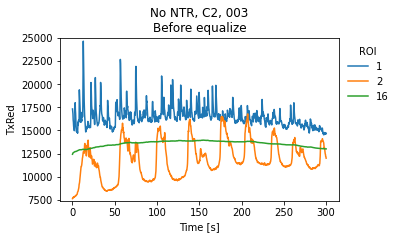

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

x = "Time [s]" 
y = "TxRed"
hue = 'ROI'
# hue_order = [1, 2, 16]
# hue_order = [str(i) for i in np.arange(1, 17)]
hue_order = ['1', '2', '16']

sns.lineplot(
    data=df_noNTR_before[df_noNTR_before['ROI'].isin(hue_order)],
    x=x, y=y,
    hue=hue, hue_order=hue_order)


# Formatting
sns.move_legend(ax,
    title='ROI', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

ax.set_ylim((7.4e3, 25e3))
plt.title('No NTR, C2, 003\nBefore equalize')

Text(0.5, 1.0, 'No NTR, C2, 003\nAfter equalize')

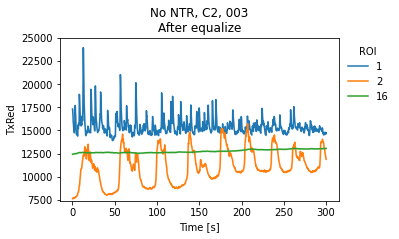

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

x = "Time [s]" 
y = "TxRed"
hue = 'ROI'
# hue_order = [1, 2, 16]
# hue_order = [str(i) for i in np.arange(1, 17)]
hue_order = ['1', '2', '16']

sns.lineplot(
    data=df_noNTR_after[df_noNTR_after['ROI'].isin(hue_order)],
    x=x, y=y,
    hue=hue, hue_order=hue_order)


# Formatting
sns.move_legend(ax,
    title='ROI', loc='upper left', bbox_to_anchor=(1,1), frameon=False)
ax.set_ylim((7.4e3, 25e3))
plt.title('No NTR, C2, 003\nAfter equalize')

# Plot each trace

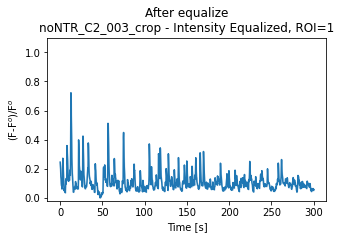

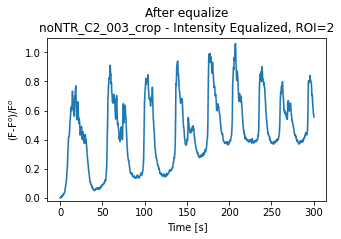

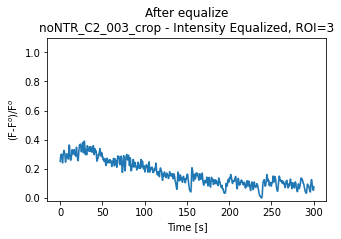

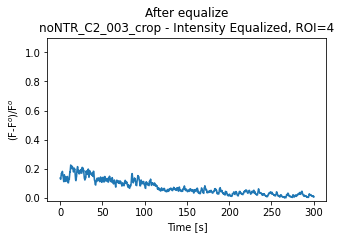

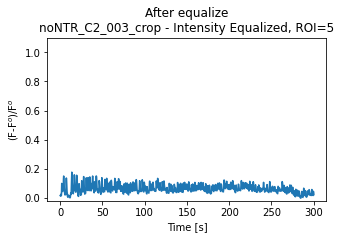

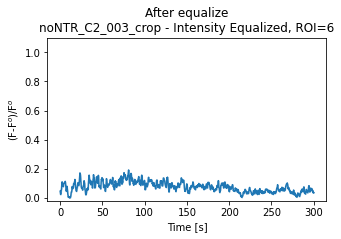

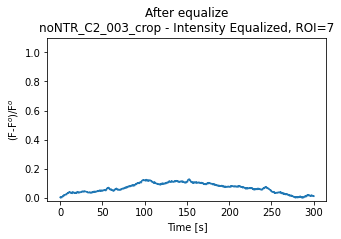

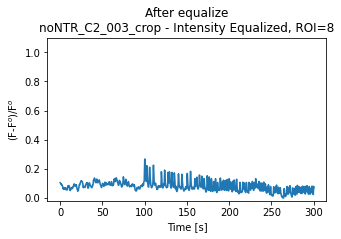

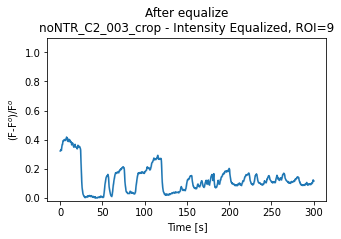

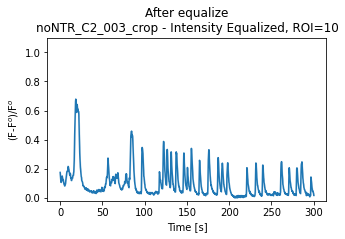

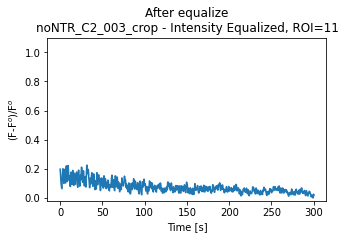

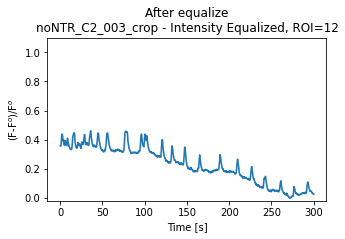

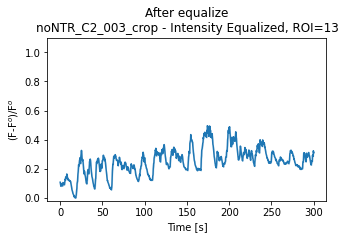

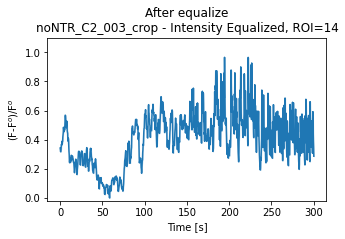

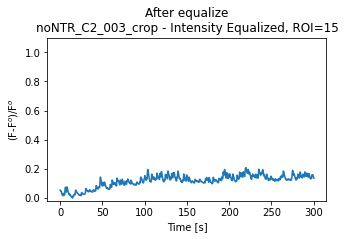

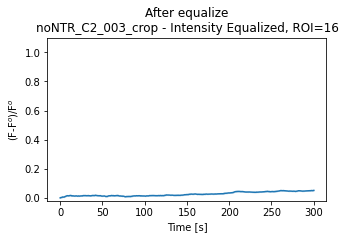

In [8]:
x = "Time [s]" 
y = "deltaF_norm"

df = df_noNTR

for ROI in df.ROI.unique():

    fig, ax = plt.subplots(1, 1, figsize=(5, 3))

    sns.lineplot(data=df[df['ROI'] == ROI], x=x, y=y)

    ax.set_ylim((-.02, 1.1))
    plt.ylabel("(F-F$^o$)/F$^o$")
    plt.title(f'After equalize\n{df.Name[0]}, ROI={ROI}')

    plt.savefig(figpath + f'jRCaMP1b-traces/{df.Name[0]}_ROI{ROI}.svg', bbox_inches='tight')

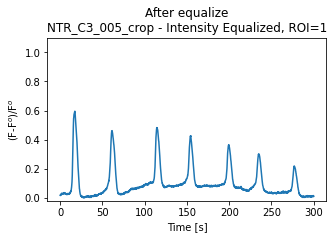

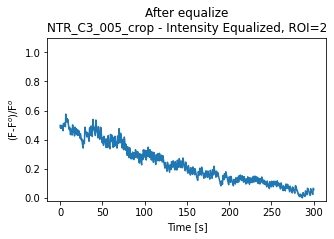

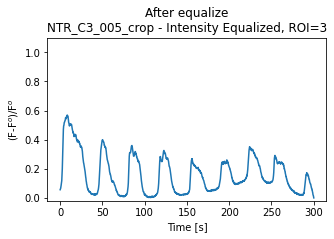

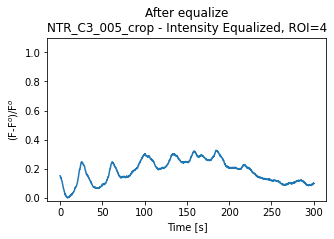

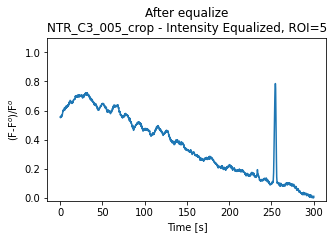

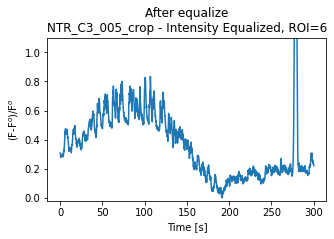

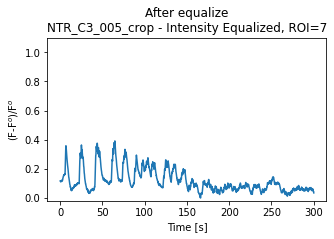

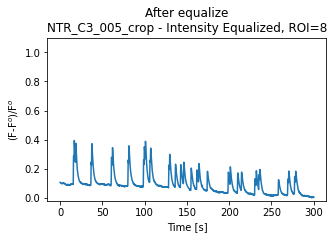

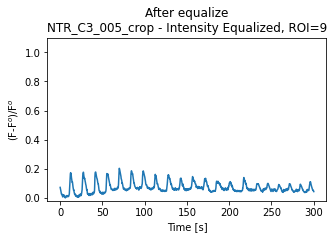

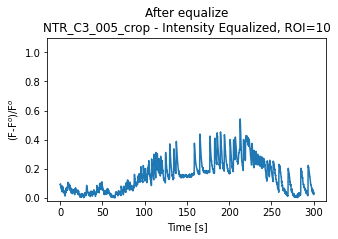

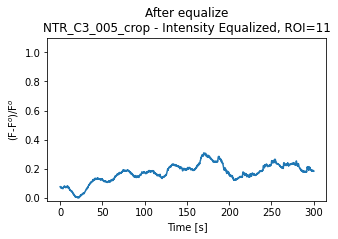

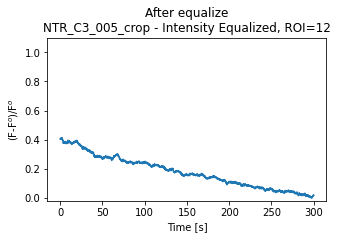

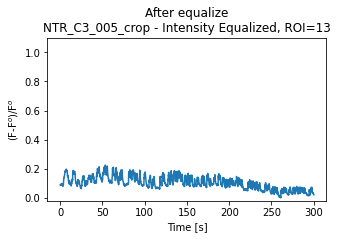

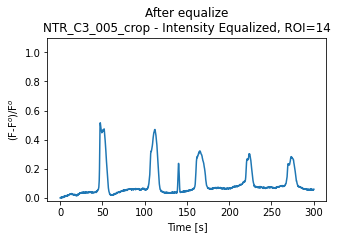

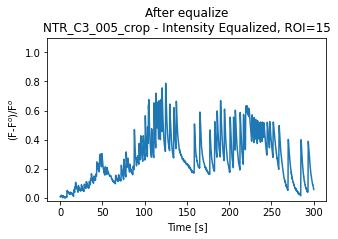

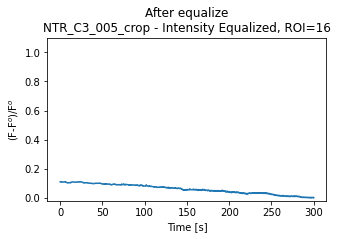

In [9]:
x = "Time [s]" 
y = "deltaF_norm"

df = df_NTR

for ROI in df.ROI.unique():

    fig, ax = plt.subplots(1, 1, figsize=(5, 3))

    sns.lineplot(data=df[df['ROI'] == ROI], x=x, y=y)

    ax.set_ylim((-.02, 1.1))
    plt.ylabel("(F-F$^o$)/F$^o$")
    plt.title(f'After equalize\n{df.Name[0]}, ROI={ROI}')

    plt.savefig(figpath + f'jRCaMP1b-traces/{df.Name[0]}_ROI{ROI}.svg', bbox_inches='tight')